# Optic flow task


This notebook illustrates the optic flow task and how to use it with our pretrained fly visual system model and decoder.

# The Sintel dataset

We use the Sintel dataset to train out models as described in the paper. Everything else you need to know about the Sintel dataset can be found on their website: http://sintel.is.tue.mpg.de/.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from flyvision.datasets.sintel import MultiTaskSintel
from flyvision.animations.sintel import SintelSample

%load_ext autoreload
%autoreload 2

The `MultiTaskSintel` class loads, preprocesses, renders, and augments the sintel data. It adheres to the pytorch dataset protocol and provides the interface to the input data and the output data of the network.

In [161]:
dataset = MultiTaskSintel(
    tasks=["flow"],
    boxfilter=dict(extent=15, kernel_size=13),
    vertical_splits=1,
    dt=1 / 24,
    augment=False,
)

# TODO: adapt below to vertical_splits=1

Sintel has 23 movie sequences.

In [162]:
np.unique(dataset.arg_df.original_index)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

Each sequence is 436 pixel in height times 1024 pixel in width. 

In [163]:
dataset.cartesian_sequence("flow", vertical_splits=1, center_crop_fraction=1.0).shape

/groups/turaga/home/lappalainenj/FlyVis/private/flyvision/flyvision/datasets/sintel.py:668: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if key in splits:


(1, 49, 436, 1024)

Because the fly eye rendering is square and sintel is wide, we can crop sintel in width and render three sequences from one. This allows us to statically augment our dataset a bit already before we proceed with the random augmentations. We end up with 3 * 23 sequences. The `dataset.arg_df` tracks the sequence index, identity etc.

In [164]:
dataset.arg_df

,index,original_index,name,original_n_frames
0,0,0,sequence_00_alley_1_split_00,50
1,1,1,sequence_01_alley_2_split_00,50
2,2,2,sequence_02_ambush_2_split_00,21
3,3,3,sequence_03_ambush_4_split_00,33
4,4,4,sequence_04_ambush_5_split_00,50
5,5,5,sequence_05_ambush_6_split_00,20
6,6,6,sequence_06_ambush_7_split_00,50
7,7,7,sequence_07_bamboo_1_split_00,50
8,8,8,sequence_08_bamboo_2_split_00,50
9,9,9,sequence_09_bandage_1_split_00,50


The first and second sample are offset crops from the same sequence.

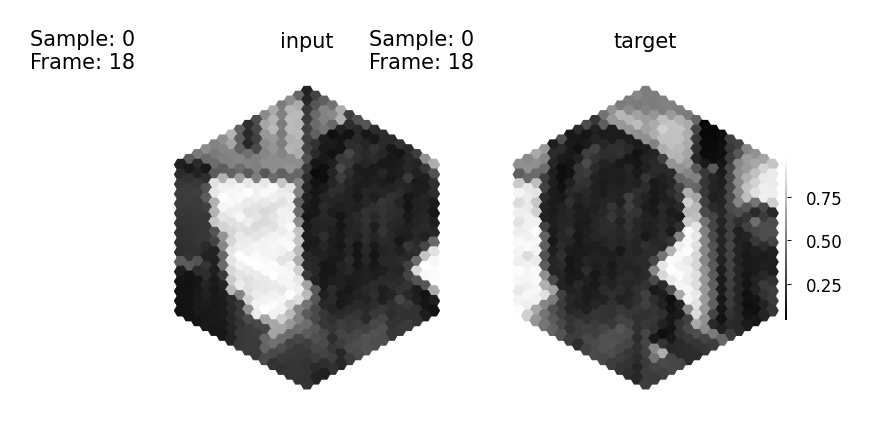

In [141]:
lum1 = dataset[0]["lum"]
lum2 = dataset[1]["lum"]

animation = SintelSample(lum1[None], lum2[None], target_cmap=plt.cm.binary_r)
animation.animate_in_notebook()

We can look at the input and the task variable jointly to get an intuition. Let's pick the second sample as example. The color indicates the direction of motion of the respective input pixel. The saturation indicates the magnitude of motion.

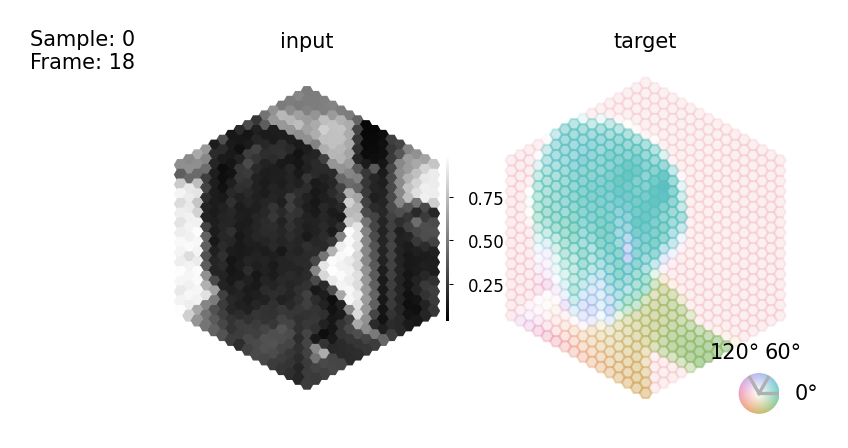

In [142]:
lum = dataset[0]["lum"]
flow = dataset[0]["flow"]

animation = SintelSample(lum[None], flow[None])
animation.animate_in_notebook()

The sintel dataset has more groundtruth annotations. Here we support depth and flow because these are somewhat sensible for the fruit fly visual system.

# Computing responses to the sintel data

Before we get to training a network, let's briefly look at a few responses to these type of sequences. 

In [143]:
from flyvision.network import NetworkView
from flyvision.utils.activity_utils import LayerActivity

from flyvision.datasets.sintel import MultiTaskSintel

In [144]:
# let's load one of our networks
network_view = flyvision.network.NetworkView(
    "opticflow/000/0000",
    checkpoint="best_chkpt",
    validation_subdir="",
    loss_file_name="validation_loss",
)

In [104]:
network = network_view.init_network()

[2024-05-27 22:42:15] [network.py:242] Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2024-05-27 22:42:15] [chkpt_utils.py:64] Recovered network state.


In [122]:
layer_activity = LayerActivity(None, network.connectome, keepref=True)

Let's create the task dataset again. This time, notice that we set the integration time constant `dt`. The framerate of the movie is 24Hz ~ 42ms between frames. But the dynamic of neural voltage in these fruit fly neurons can be on the order of 20ms. Therefore, let's integrate the dynamics with a small integration timestep of 5ms. Notice, that we set `resampling=True`, and `interpolate=True` to resample input images at a higher frequency and interpolate optic flow targets between timepoints.

In [148]:
dataset = MultiTaskSintel(
    tasks=["flow"],
    boxfilter=dict(extent=15, kernel_size=13),
    vertical_splits=1,
    n_frames=19,
    dt=5e-3,
    augment=False,
    resampling=True,
    interpolate=True,
)

In [158]:
stationary_state = network.fade_in_state(1.0, dataset.dt, dataset[0]["lum"][[0]])
responses = network.simulate(dataset[0]["lum"][None], dataset.dt, initial_state=stationary_state).cpu()

[2024-05-27 23:28:09] [legend.py:1323] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


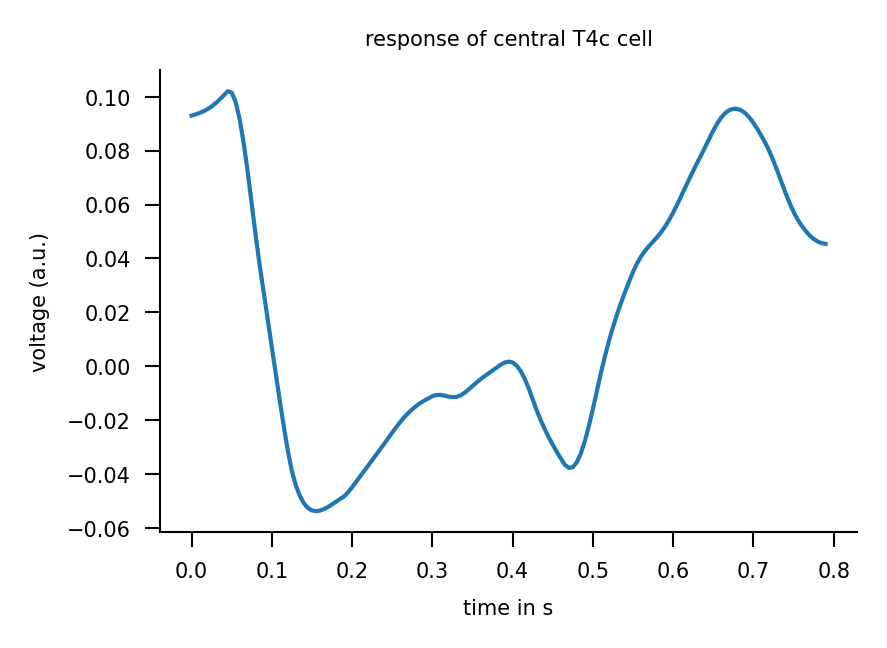

In [159]:
plt.figure(figsize=[3, 2])
layer_activity.update(responses)
r = layer_activity.central.T4c.squeeze().numpy()
time = np.arange(0, r.shape[0], 1) * dataset.dt
plt.plot(time, r)
plt.xlabel("time in s")
plt.ylabel("voltage (a.u.)")
plt.title("response of central T4c cell")
plt.legend()

# Decoding the task from the neural activity

Decreasing the integration time step will lead to smoother data. This is due to the numerical integration. When choosing this, we have to trade-off computational ressources with accuracy.

Fruit fly neurons are not particularly fast. We also don't know if sintel has the right temporal statistics for fruit fly brains. Therefore, we are fine with temporal dynamics of our networks being a bit slower than other neural simulators. Here we spare ressources to train many models and to 

In [166]:
from flyvision.network import NetworkView
from flyvision.utils.activity_utils import LayerActivity

from flyvision.datasets.sintel import MultiTaskSintel

In [167]:
# let's load one of our networks
network_view = flyvision.network.NetworkView(
    "opticflow/000/0000",
    checkpoint="best_chkpt",
    validation_subdir="",
    loss_file_name="validation_loss",
)

In [168]:
network = network_view.init_network()

[2024-06-02 21:30:42] [network.py:242] Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2024-06-02 21:30:42] [chkpt_utils.py:64] Recovered network state.


In [175]:
decoder = network_view.init_decoder()

[2024-06-02 21:37:27] [decoder.py:217] Initialized decoder with NumberOfParams(free=7427, fixed=0) parameters.
[2024-06-02 21:37:27] [decoder.py:218] DecoderGAVP(
  (base): Sequential(
    (0): Conv2dHexSpace(34, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Softplus(beta=1, threshold=20)
    (3): Dropout(p=0.5, inplace=False)
  )
  (decoder): Sequential(
    (0): Conv2dHexSpace(8, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (head): Sequential()
)
[2024-06-02 21:37:27] [chkpt_utils.py:80] Recovered flow decoder state.


In [206]:
dataset = MultiTaskSintel(
    tasks=["flow"],
    boxfilter=dict(extent=15, kernel_size=13),
    vertical_splits=1,
    all_frames=True,
    dt=1/50,
    augment=False,
    resampling=True,
    interpolate=True,
)

In [208]:
data = dataset[0]
lum = data["lum"]
flow = data["flow"]

stationary_state = network.fade_in_state(1.0, dataset.dt, lum[[0]])
responses = network.simulate(lum[None], dataset.dt, initial_state=stationary_state)

In [209]:
y_pred = decoder["flow"](responses)

The loss this is minimizing is the average end-point-error.

In [210]:
((y_pred - flow) ** 2).sqrt().mean()

tensor(0.8255, device='cuda:0', grad_fn=<MeanBackward0>)

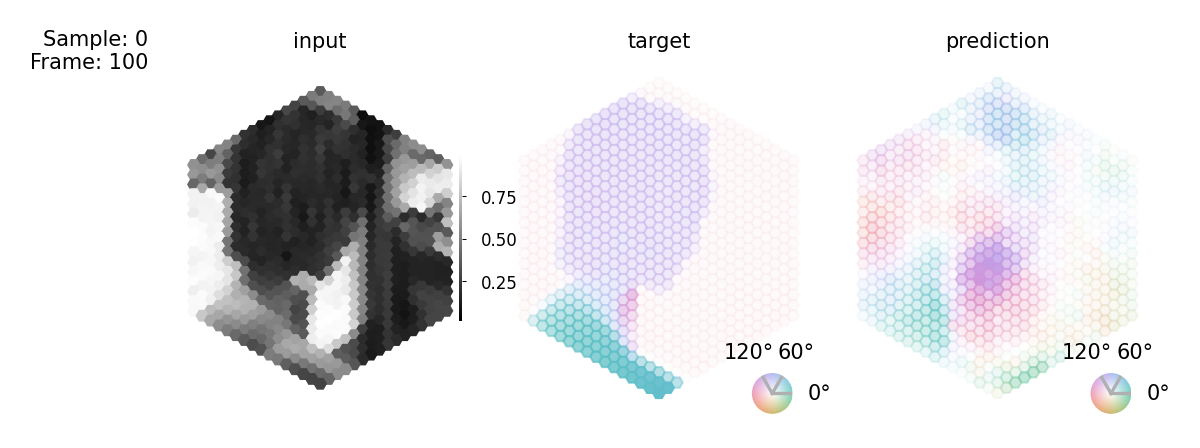

In [211]:
animation = SintelSample(lum[None], flow[None], prediction=y_pred.detach().cpu())
animation.animate_in_notebook(frames=np.arange(lum.shape[0])[::10])

# Training network and decoder on a single batch

Let's train the network ourselves on a single batch to see that the pipeline works.

Note: this is severely overfitting and these networks won't develop meaningful function, it's to illustrate and debug.

In [305]:
from tqdm.notebook import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader

from flyvision.network import NetworkView, Network
from flyvision.decoder import DecoderGAVP
from flyvision.utils.activity_utils import LayerActivity

from flyvision.datasets.sintel import MultiTaskSintel
from flyvision.objectives import L2Norm, EPE

In [306]:
network = Network()

[2024-06-02 22:02:17] [network.py:243] Initialized network with NumberOfParams(free=734, fixed=2959) parameters.


In [307]:
decoder = DecoderGAVP(network.connectome, shape=[8, 2], kernel_size=5)

[2024-06-02 22:02:21] [decoder.py:217] Initialized decoder with NumberOfParams(free=7427, fixed=0) parameters.
[2024-06-02 22:02:21] [decoder.py:218] DecoderGAVP(
  (base): Sequential(
    (0): Conv2dHexSpace(34, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Softplus(beta=1, threshold=20)
    (3): Dropout(p=0.5, inplace=False)
  )
  (decoder): Sequential(
    (0): Conv2dHexSpace(8, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (head): Sequential()
)


In [308]:
dataset = MultiTaskSintel(
    tasks=["flow"],
    boxfilter=dict(extent=15, kernel_size=13),
    vertical_splits=1,
    n_frames=19,
    dt=1/50,
    augment=False,
    resampling=True,
    interpolate=True,
)

In [309]:
t_pre=0.5
dt = 1/50
batch_size=4
train_loader = DataLoader(dataset, batch_size=batch_size)

In [310]:
optimizer = Adam((*network.parameters(), *decoder.parameters()), lr=1e-5)

In [311]:
batch = next(iter(train_loader))

In [312]:
loss_fn = EPE()

In [313]:
epochs = 1000

errors = []
for e in tqdm(range(epochs)):
    lum = batch["lum"]
    flow = batch["flow"]
    
    initial_state = network.steady_state(t_pre, dt, batch_size)
    
    optimizer.zero_grad()
    network.stimulus.zero()
    network.stimulus.add_input(lum)
    
    activity = network(network.stimulus(), dt=1/50, state=initial_state)
    y_pred = decoder(activity)

    batch_error = loss_fn(y_pred, flow)
    errors.append(batch_error.cpu().item())
    batch_error.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

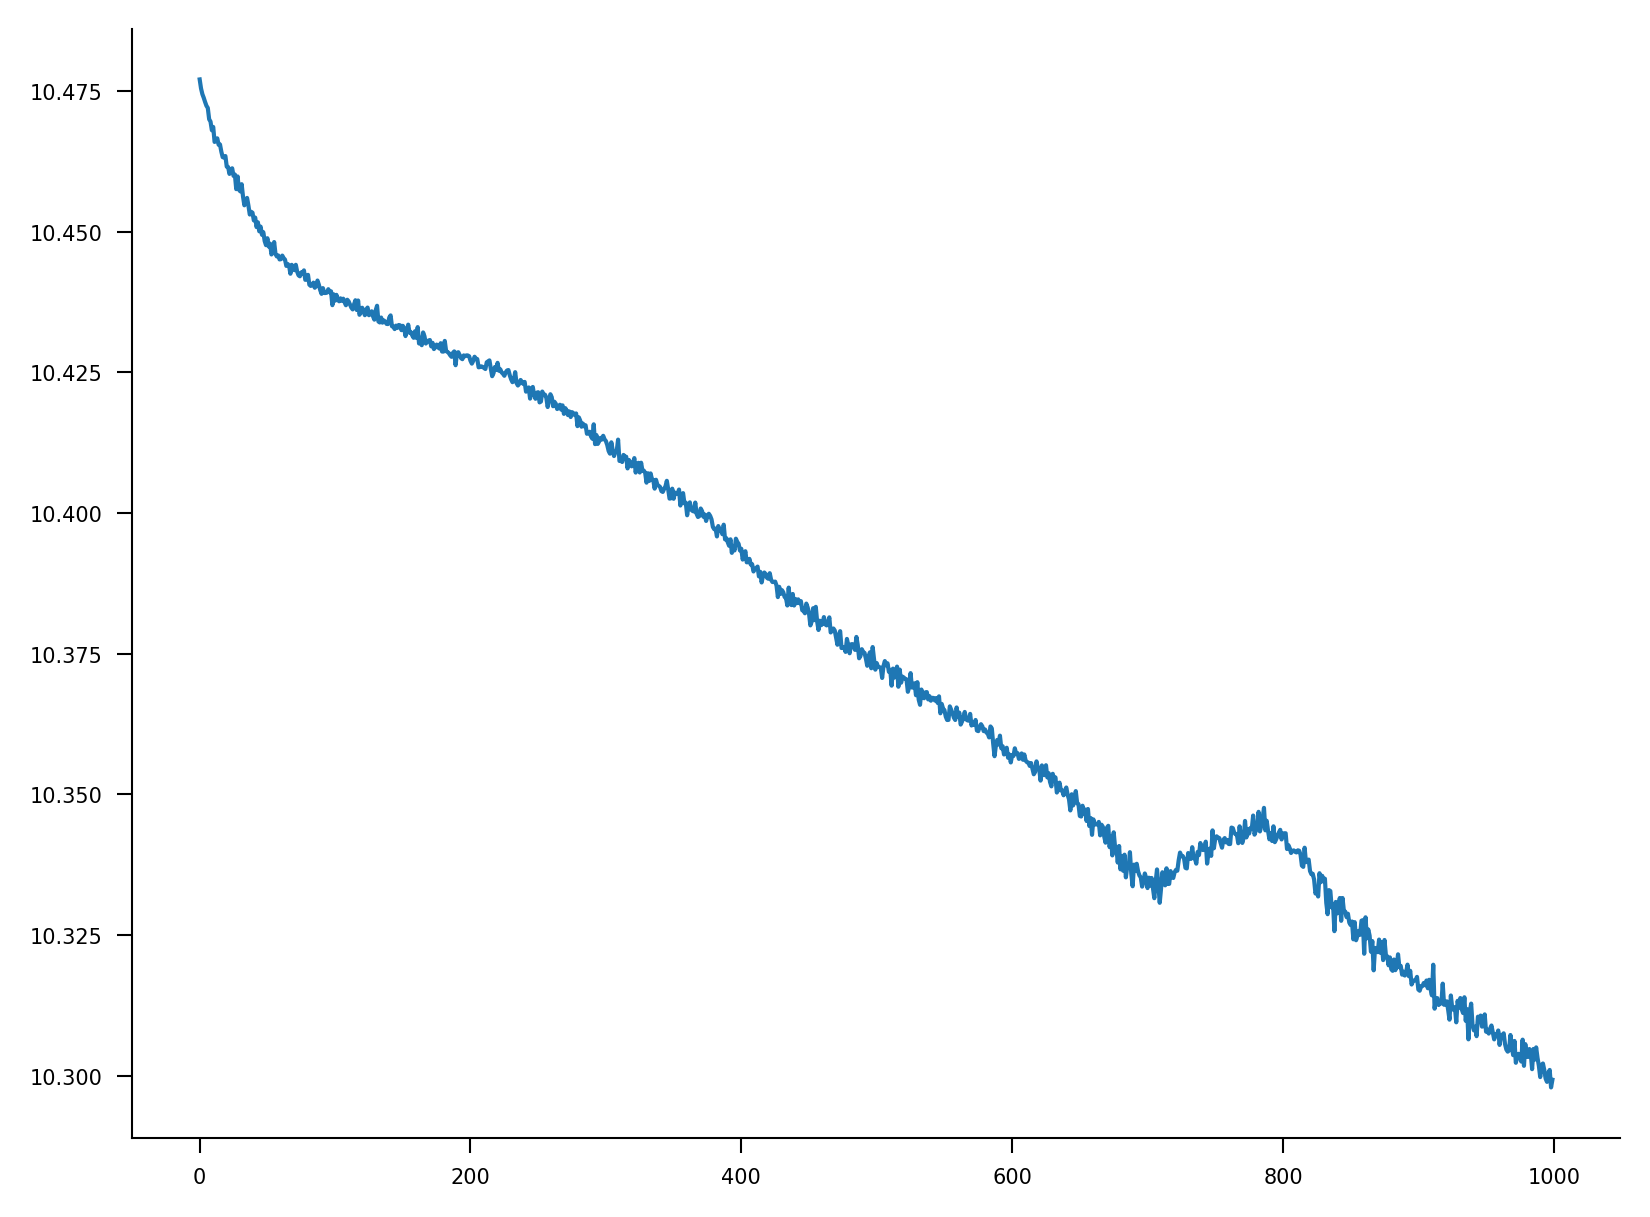

In [314]:
plt.plot(errors)

# Evaluating trained networks

We made a few simplifications so far to keep it simple for the beginning. The network is trained on the whole dataset, that we heavly augment, both in preprocessing and at runtime. This is standard in deep learning for computer vision.

In comparison to the training algorithm above, the actual algorithm adds a learning rate schedule and an activity penalty on the biases to reduce the number of dead cell types after training.

In [2]:
from flyvision.datasets.sintel import MultiTaskSintel

In [5]:
dataset = MultiTaskSintel(tasks=["flow"],
        boxfilter=dict(extent=15, kernel_size=13),
        # Because the fly eye rendering is square 
        # and sintel is wide, we can crop sintel 
        # in width and render three sequences from one. 
        # This allows us to statically augment our dataset 
        # a bit already before we proceed with the random augmentations. 
        # We end up with 3 * 23 sequences. 
        vertical_splits=3,
        n_frames=19,
        center_crop_fraction=0.7,
        dt=1 / 50,
        augment=True,
        # From sequences with more than n_frames, we randomly sample the start frame.
        random_temporal_crop=True,
        all_frames=False,
        # We resample movie frames to the effective framerate given by 1/dt
        resampling=True,
        # We interpolate the flow arrows to 1/dt.
        interpolate=True,
        # We flip with equal probability (using one flip-axis).
        p_flip=0.5,
        # We rotate with equal probability (using five fold rotation symmetry of the hex-grid).
        p_rot=5 / 6,
        # We randomly adjust contrast and brightness.
        contrast_std=0.2,
        brightness_std=0.1,
        # We add random white noise pixelweise.
        gaussian_white_noise=0.08,
        gamma_std=None,
        _init_cache=True,
        unittest=False,
        flip_axes=[0, 1],
        task_weights=None,)

/home/lappalainenj@hhmi.org/miniconda3/envs/flyvision/lib/python3.9/site-packages/datamate/directory.py:450: ModifiedWarning: Skipping Directory /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/SintelDataSet/RenderedSintel_0011, which has been modified after  being build.
You can use the explicit path as constructor (see  Directory docs).
  cls = _directory_from_config(cls, config)


In [318]:
# The `dataset.arg_df` tracks the sequence index, identity etc.
dataset.arg_df

,index,original_index,name,original_n_frames
0,0,0,sequence_00_alley_1_split_00,50
1,1,0,sequence_00_alley_1_split_01,50
2,2,0,sequence_00_alley_1_split_02,50
3,3,1,sequence_01_alley_2_split_00,50
4,4,1,sequence_01_alley_2_split_01,50
...,...,...,...,...
64,64,21,sequence_21_temple_2_split_01,50
65,65,21,sequence_21_temple_2_split_02,50
66,66,22,sequence_22_temple_3_split_00,50
67,67,22,sequence_22_temple_3_split_01,50


We trained 50 networks, which we first evaluated on the task error. We share the best model checkpoints and their validation errors. Let's look at the loss histogram below. This is the minimal validation loss across all checkpoints made during training. 

In [3]:
from flyvision.ensemble import EnsembleView

In [28]:
ensemble = EnsembleView("opticflow/000", 
                        checkpoint='best_chkpt',
                        validation_subdir='',
                        loss_file_name='validation_loss',
                        )

Loading ensembles:   0%|          | 0/50 [00:00<?, ?it/s]

(<Figure size 300x300 with 1 Axes>,
 <Axes: xlabel='task error', ylabel='number models'>)

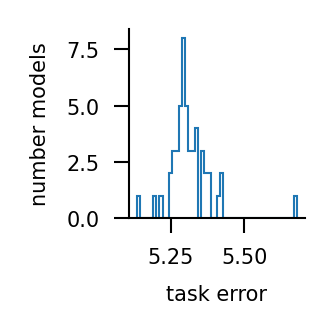

In [29]:
ensemble.loss_histogram()